<a href="https://colab.research.google.com/github/truong2710-cyber/NMT-LSTM-Attention-Model/blob/main/Neutral_Machine_Translation_English_to_French_Attention_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip show tensorflow


Name: tensorflow
Version: 2.0.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: grpcio, astor, protobuf, termcolor, wheel, opt-einsum, gast, absl-py, numpy, wrapt, keras-preprocessing, six, google-pasta, tensorflow-estimator, keras-applications, tensorboard
Required-by: kapre


In [ ]:
!pip uninstall tensorflow

Uninstalling tensorflow-2.0.0:
  Would remove:
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.0.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
    /usr/local/lib/python3.7/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.0.0


In [ ]:
!pip install tensorflow==2.0.0

  Using cached https://files.pythonhosted.org/packages/2a/5c/f1d66de5dde6f3ff528f6ea1fd0757a0e594d17debb3ec7f82daa967ea9a/tensorflow-2.0.0-cp37-cp37m-manylinux2010_x86_64.whl


In [ ]:
pip show tensorflow

Name: tensorflow
Version: 2.0.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, six, absl-py, tensorflow-estimator, google-pasta, termcolor, wheel, protobuf, tensorboard, astor, keras-applications, wrapt, opt-einsum, keras-preprocessing, grpcio, gast
Required-by: kapre


In [ ]:
pip install d2l

In [ ]:
import os
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l
from tensorflow.keras.layers import Dense, RepeatVector, Activation, Bidirectional, BatchNormalization, LSTM, Concatenate,Dot,Softmax,Input

In [ ]:
#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [ ]:
#@save
def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [
        ' ' + char if i > 0 and no_space(char, text[i - 1]) else char
        for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [ ]:
#@save
def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
print(len(source))
source[:6], target[:6]

167130


([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

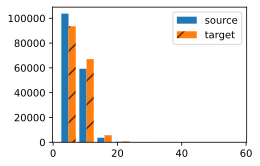

In [ ]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist([[len(l)
                               for l in source], [len(l) for l in target]],
                             label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right')

In [ ]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
# dictionary for source
src_vocab[['you','are']]

[6, 26]

In [ ]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
#@save
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = tf.constant([
        truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = tf.reduce_sum(tf.cast(array != vocab['<pad>'], tf.int32), 1)
    return array, valid_len

In [ ]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=167130):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    src_array=tf.one_hot(src_array,depth=len(src_vocab),axis=-1)
    tgt_array=tf.one_hot(tgt_array,depth=len(tgt_vocab),axis=-1)
    data_arrays = (src_array, tgt_array,)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [ ]:

batch_size=10000
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=batch_size, num_steps=8,num_examples=10000)
Tx=8
Ty=8
src_vocab_size=len(src_vocab)
tgt_vocab_size=len(tgt_vocab)
print(src_vocab_size)

for X_iter, Y_iter  in train_iter:
    X=X_iter
    Y=Y_iter
    print('X:', X)
    
    print('Y:', Y)
    
    break


1505
X: tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 

In [ ]:
repeator=RepeatVector(Tx)
concatenator=Concatenate()
densor1=Dense(10,activation='tanh')
densor2=Dense(1,activation='relu')
activator=Softmax(axis=1)
dotor=Dot(axes=1)

In [ ]:
def one_step_attention(a,s_prev):
    """
    Perform one step of attention
    a: output of pre-attention BiLSTM layer, shape=(m,Tx,2*n_a)
    s_prev: previous hidden state of post-attention LSTM, shape=(m,n_s)
    """
    s=repeator(s_prev)               # now s.shape=(m,Tx,n_s)
    input_to_dense=concatenator([s,a]) # input_to_dense.shape=(m,Tx, n_s+2*n_a)
    out1=densor1(input_to_dense)              # out1.shape=(m,Tx,10)
    e=densor2(out1)                  # e.shape=(m,Tx,1)
    alphas=activator(e)              # aphas.shape=(m,Tx,1)
    context=dotor([alphas,a])         # context.shape=(m,1,2*n_a)
    return context

In [ ]:
n_a=32
n_s=64
post_attention_LSTM_cell=LSTM(n_s,return_state=True)
output_layer=Dense(len(tgt_vocab),activation=Softmax(axis=-1))

In [ ]:
def my_model(Tx,Ty,n_a,n_s,src_vocab_size,tgt_vocab_size):
    '''
    Tx: length of input sentence
    Ty: length of output sentence
    n_a: hidden state size of pre-attention BiLSTM
    n_s: hidden state size of post-attention LSTM
    src_vocab_size: source vocab size (English)
    tgt_vocab_size: target vocab size (French)
    '''
    X=Input(shape=(Tx,src_vocab_size))
    s0=Input(shape=(n_s,))
    c0=Input(shape=(n_s,))
    s=s0
    c=c0
    outputs=[]
    # Pre-attention BiLSTM, output shape = (m,Tx,2*n_a)
    a=Bidirectional(LSTM(units=n_a,return_sequences=True))(X)

    for t in range(Ty):
        context=one_step_attention(a,s)
        s,y,c=post_attention_LSTM_cell(inputs=context,initial_state=[s, c])
        out=output_layer(inputs=s)
        outputs.append(out)
    

    model=tf.keras.models.Model(inputs=[X,s0,c0],outputs=outputs)
    return model


In [ ]:
model=my_model(Tx,Ty,n_a,n_s,src_vocab_size,tgt_vocab_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 8, 1505)]    0                                            
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 8, 64)        0           input_2[0][0]                    
                                                                 lstm[0][0]                       
                                                                 lstm[1][0]                       
                                                                 lstm[2][0]                   

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.005,beta_1=0.9,beta_2=0.999,decay=0.01) 
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [ ]:

s0=np.zeros((batch_size,n_s))
c0=np.zeros((batch_size,n_s))
outputs = list(tf.transpose(Y, [1, 0, 2]))
model.fit([X,s0,c0],outputs,epochs=300,verbose=1,batch_size=32)

Train on 10000 samples
Epoch 1/300
10000/10000 [==============================] - 51s 5ms/sample - loss: 26.8972 - dense_2_loss: 5.2930 - dense_2_1_loss: 6.1659 - dense_2_2_loss: 6.0242 - dense_2_3_loss: 3.9884 - dense_2_4_loss: 2.4881 - dense_2_5_loss: 1.4550 - dense_2_6_loss: 0.8634 - dense_2_7_loss: 0.6096 - dense_2_accuracy: 0.1513 - dense_2_1_accuracy: 0.0263 - dense_2_2_accuracy: 0.0774 - dense_2_3_accuracy: 0.2445 - dense_2_4_accuracy: 0.3648 - dense_2_5_accuracy: 0.6559 - dense_2_6_accuracy: 0.8701 - dense_2_7_accuracy: 0.9604
Epoch 2/300
10000/10000 [==============================] - 29s 3ms/sample - loss: 22.6872 - dense_2_loss: 4.5176 - dense_2_1_loss: 5.6945 - dense_2_2_loss: 5.4535 - dense_2_3_loss: 3.3697 - dense_2_4_loss: 1.9545 - dense_2_5_loss: 1.0154 - dense_2_6_loss: 0.4755 - dense_2_7_loss: 0.2027 - dense_2_accuracy: 0.1953 - dense_2_1_accuracy: 0.0631 - dense_2_2_accuracy: 0.1192 - dense_2_3_accuracy: 0.4026 - dense_2_4_accuracy: 0.5366 - dense_2_5_accuracy: 0.7173

In [ ]:
sentences=["who?"]
def convert_to_input(sentences):
    out=[]
    for s in sentences:
        l=s.lower().split(" ")
        end_mark=l[-1][-1]
        l[-1]=l[-1][:-1]
        l.append(end_mark)

        out.append([src_vocab[w] for w in l])
    out = [truncate_pad(i, num_steps=8, padding_token=src_vocab['pad']) for i in out]
    return out
X_test=tf.one_hot(convert_to_input(sentences),depth=len(src_vocab),axis=-1)
s00=np.zeros((1,n_s))
c00=np.zeros((1,n_s))
y=model.predict([X_test,s00,c00])
print(tgt_vocab.token_to_idx)
y=np.array(y).swapaxes(0,1)
print(y.shape)
pred=np.argmax(y,axis=-1)
print(pred)
print(" ".join([tgt_vocab.idx_to_token[i] for i in pred[0]]))


{'<unk>': 0, '<pad>': 1, '<bos>': 2, '<eos>': 3, '.': 4, 'je': 5, '!': 6, '?': 7, 'suis': 8, 'nous': 9, 'pas': 10, 'il': 11, 'vous': 12, 'tom': 13, "c'est": 14, 'ne': 15, "j'ai": 16, 'de': 17, 'est': 18, 'le': 19, 'me': 20, 'un': 21, 'en': 22, 'tu': 23, 'à': 24, 'la': 25, 'ça': 26, 'les': 27, 'a': 28, 'sommes': 29, 'une': 30, 'êtes': 31, 'est-ce': 32, 'elle': 33, 'qui': 34, 'es': 35, ',': 36, 'que': 37, 'sont': 38, 'fait': 39, 'ils': 40, 'êtes-vous': 41, 'bien': 42, 'elles': 43, 'soyez': 44, 'y': 45, 'des': 46, 'faut': 47, 'été': 48, 'ce': 49, 'besoin': 50, 'te': 51, 'aller': 52, 'ici': 53, 'du': 54, 'ai': 55, 'va': 56, 'sois': 57, "l'ai": 58, 'avons': 59, 'moi': 60, "j'aime": 61, 'train': 62, "n'est": 63, 'tout': 64, 'es-tu': 65, "l'air": 66, 'partir': 67, "j'étais": 68, 'mon': 69, 'fais': 70, 'veux': 71, 'sens': 72, 'ont': 73, 'peux': 74, 'se': 75, 'puis-je': 76, 'toi': 77, 'on': 78, "m'a": 79, 'au': 80, "j'adore": 81, 'cela': 82, 'est-il': 83, "c'était": 84, 'personne': 85, 'mal': 8